In [68]:
import os
import zipfile
import json
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
os.chdir('/content/drive/MyDrive/Google io ML')

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

In [4]:
dir = "news-headlines-dataset-for-sarcasm-detection.zip"
fl = zipfile.ZipFile(dir , "r")

In [5]:
fl.extractall()

In [38]:
data_dir = "Sarcasm_Headlines_Dataset.json"
with open(data_dir , 'r') as F:
  a = F.read()
data  = []
label = []
for each_data in a.split('\n')[:-1]:
  data.append(json.loads(each_data)['headline'])
  label.append(json.loads(each_data)['is_sarcastic'])

In [39]:
print("Len of data is : " , len(data))
print("Len of label is : " , len(label))

Len of data is :  26709
Len of label is :  26709


In [40]:
msg_length = [len(m) for m in data]
print("Max length of the msg : " , max(msg_length))

Max length of the msg :  254


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([2.980e+02, 1.338e+03, 3.649e+03, 5.529e+03, 6.901e+03, 5.522e+03,
        2.277e+03, 7.910e+02, 2.900e+02, 7.800e+01, 2.100e+01, 9.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00]),
 array([  7.  ,  19.35,  31.7 ,  44.05,  56.4 ,  68.75,  81.1 ,  93.45,
        105.8 , 118.15, 130.5 , 142.85, 155.2 , 167.55, 179.9 , 192.25,
        204.6 , 216.95, 229.3 , 241.65, 254.  ]),
 <a list of 20 Patch objects>)

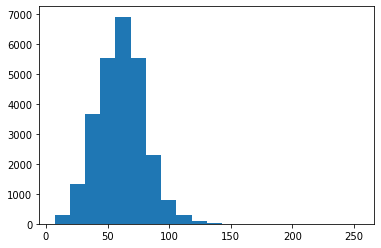

In [46]:
plt.hist(msg_length , bins=20)

In [47]:
maxlen = 80
vocab_size = 10000
padding = 'post'
truncating = 'post'
oov_token = "<oov>"
emb_dim = 32

In [48]:
import tensorflow as tf
print("Version of tf is : ",tf.__version__)

Version of tf is :  2.3.0


In [49]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size , oov_token=oov_token)

In [ ]:
tokenizer.fit_on_texts(data)
tokenizer.word_index

In [51]:
text_to_seq = tokenizer.texts_to_sequences(data)
pad_data = tf.keras.preprocessing.sequence.pad_sequences(text_to_seq , maxlen=maxlen , padding=padding , truncating=truncating)

In [52]:
print("Shape of data : ",pad_data.shape)

Shape of data :  (26709, 80)


In [54]:
train_data  = pad_data[:20000]
train_label = np.array(label[:20000])

test_data  = pad_data[20000:]
test_label = np.array(label[20000:])

In [55]:
print(train_data.shape)
print(train_label.shape)
print("---------------------")
print(test_data.shape)
print(test_label.shape)

(20000, 80)
(20000,)
---------------------
(6709, 80)
(6709,)


In [62]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size , emb_dim , input_length = maxlen),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(32 , activation='relu'),
  tf.keras.layers.Dense(1 , activation="sigmoid")
])
model1.compile(loss = tf.keras.losses.binary_crossentropy , optimizer = "rmsprop" , metrics = ['acc'])
model1.summary()
history1 = model1.fit(train_data , train_label , epochs=30 , validation_data=(test_data , test_label))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 32)            320000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.6560 - acc: 0.6047 - val_loss: 0.5748 - val_acc: 0.7556
Epoch 2/30
625/625 [==============================] - 3s 4ms/step - loss: 0.4668 - acc: 0.8061 - val_loss: 0.4212 

In [69]:
def plot_his(h):
  history = h.history
  f , ax = plt.subplots(1,2,figsize=(16,5))
  ax[0].plot(history['acc'] , label="train")
  ax[0].plot(history['val_acc'] , label="test")
  ax[0].legend()

  ax[1].plot(history['loss'] , label="train")
  ax[1].plot(history['val_loss'] , label="test")
  ax[1].legend()

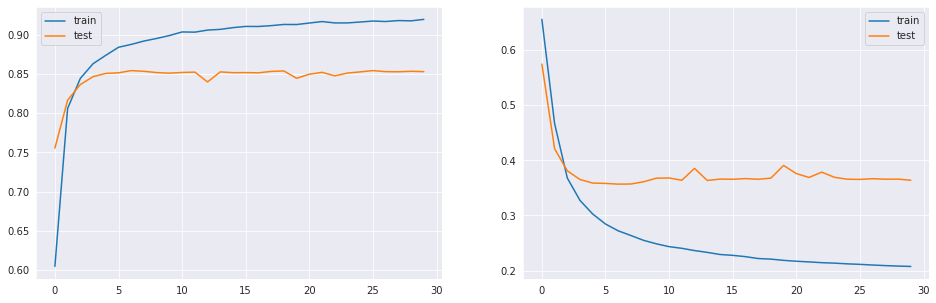

In [70]:
plot_his(history1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 80, 32)            320000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 327,361
Trainable params: 327,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
625/625 [==============================] - 9s 14ms/step - loss: 0.4214 - acc: 0.7962 - val_loss: 0.3615 - val_acc: 0.8460
Epoch 2/30
625/625 [==============================] - 9s 14ms/step - loss: 0.2752 - acc: 0.8830 - val_loss: 0.331

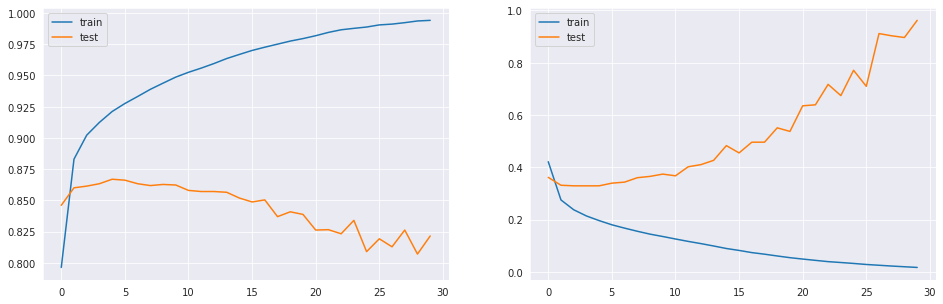

In [75]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size , emb_dim , input_length = maxlen),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
  tf.keras.layers.Dense(32 , activation='relu'),
  tf.keras.layers.Dense(1 , activation="sigmoid")
])
model2.compile(loss = tf.keras.losses.binary_crossentropy , optimizer = "rmsprop" , metrics = ['acc'])
model2.summary()
history2 = model2.fit(train_data , train_label , epochs=30 , validation_data=(test_data , test_label))
plot_his(history2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 80, 32)            320000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 80, 128)           49664     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

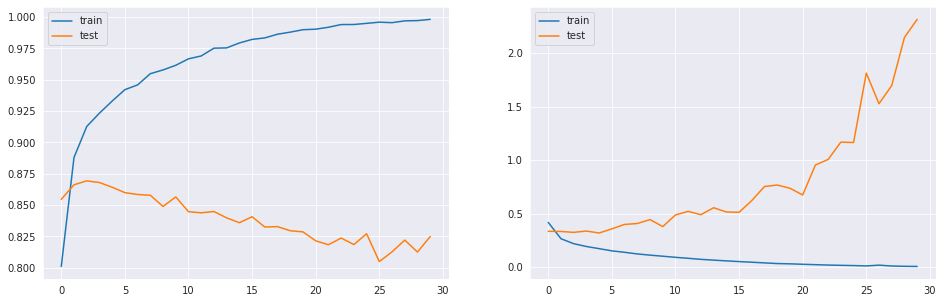

In [76]:
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size , emb_dim , input_length = maxlen),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64 , return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64 , activation='relu'),
  tf.keras.layers.Dense(32 , activation='relu'),
  tf.keras.layers.Dense(16 , activation='relu'),
  tf.keras.layers.Dense(1 , activation="sigmoid")
])
model3.compile(loss = tf.keras.losses.binary_crossentropy , optimizer = "rmsprop" , metrics = ['acc'])
model3.summary()
history3 = model3.fit(train_data , train_label , epochs=30 , validation_data=(test_data , test_label))
plot_his(history3)